# Poisson regression (GAM) COVID-19 Prediction

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import preprocess_data, StemPoissonRegressor
from utils import get_covid_data, get_all_covid_data

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [3]:
# # Read in data
active_cases_provinces = get_all_covid_data(level='prov')

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()
provinces = ['Ontario', 'Quebec', 'BC', 'Alberta']

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0       0          0   
1                  0             0                    0       0          0   
2                  0             0                    0       0          0   
3                  0             0                    0       0          0   
4                  0             0                    0       0          0   
5                  0             0                    0       0          0   
6                  0             0                    0       0          0   
7                  0             0                    0       0          0   
8                  0             0                    0       0          0   
9                  0             0                    0       0          0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876        0      4421876                  1.0  
1      0     4421876        0      4421876                  1.0  
2      0     4421876        0      4421876                  1.0  
3      0     4421876        0      4421876                  1.0  
4      0     4421876        0      4421876                  1.0  
5      0     4421876        0      4421876                  1.0  
6      0     4421876        0      4421876                  1.0  
7      0     4421876        0      4421876                  1.0  
8      0     4421876        0      4421876                  1.0  
9      0     4421876        0      4421876                  1.0

In [4]:
# Remove data before March 8
remove_date = date(day=8, month=3, year=2020)
active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

# Ignore provinces with very little cases
provinces_ignore = ['PEI', 'New Brunswick', 'NWT', 'NL', 'Nova Scotia', 'Nunavut', 'Yukon']
active_cases_provinces = active_cases_provinces.query("province not in @provinces_ignore").reset_index(drop=True)

### Comments

- Mortality data starts March 8, 2020 so we will just ignore all dates before March 1. 

## Poisson regression

For a given province $i$ we have

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

We will also be applying cross-validation on each fold to prevent overfitting.

In [5]:
# Preprocess data
active_cases_provinces_preprocessed = preprocess_data(active_cases_provinces, drop_first_day=True)
X = active_cases_provinces_preprocessed
Y = active_cases_provinces_preprocessed[['province', 'date', 'cases', 'removed']]

### Linear terms GAM

In [6]:
# Fit model
model = StemPoissonRegressor(lam_main=0.6, lam_other=100)
model.fit(X, Y)

In [7]:
# Get 3 week forecasts
forecasts = model.forecast(h=21)
forecasts = forecasts.merge(active_cases_provinces, how='left', on=['province', 'date'])

forecasts.tail(10)

province        date  active_cases_pred   cases_pred  removed_pred  \
1706      Manitoba  2020-12-18        9022.335819   483.858117    483.999889   
1707       Ontario  2020-12-18       16769.960288  1624.864114   1631.986051   
1708        Quebec  2020-12-18       11438.935783  1564.976982   1586.919926   
1709  Saskatchewan  2020-12-18        3322.157165   308.878303    308.864415   
1710       Alberta  2020-12-19       14931.737988  1446.948238   1446.892662   
1711            BC  2020-12-19        9183.763104   820.684085    820.779632   
1712      Manitoba  2020-12-19        9022.187839   483.981420    484.129400   
1713       Ontario  2020-12-19       16762.558208  1622.839319   1630.241400   
1714        Quebec  2020-12-19       11416.163912  1562.206814   1584.978684   
1715  Saskatchewan  2020-12-19        3322.171683   308.936280    308.921761   

     is_forecast  cumulative_cases  cumulative_recovered  cumulative_deaths  \
1706        True               NaN                   NaN                NaN   
1707        True               NaN                   NaN                NaN   
1708        True               NaN                   NaN                NaN   
1709        True               NaN                   NaN                NaN   
1710        True               NaN                   NaN                NaN   
1711        True               NaN                   NaN                NaN   
1712        True               NaN                   NaN                NaN   
1713        True               NaN                   NaN                NaN   
1714        True               NaN                   NaN                NaN   
1715        True               NaN                   NaN                NaN   

      active_cases  active_cases_change  deaths  recovered  cases  population  \
1706           NaN                  NaN     NaN        NaN    NaN         NaN   
1707           NaN                  NaN     NaN        NaN    NaN         NaN   
1708           NaN                  NaN     NaN        NaN    NaN         NaN   
1709           NaN                  NaN     NaN        NaN    NaN         NaN   
1710           NaN                  NaN     NaN        NaN    NaN         NaN   
1711           NaN                  NaN     NaN        NaN    NaN         NaN   
1712           NaN                  NaN     NaN        NaN    NaN         NaN   
1713           NaN                  NaN     NaN        NaN    NaN         NaN   
1714           NaN                  NaN     NaN        NaN    NaN         NaN   
1715           NaN                  NaN     NaN        NaN    NaN         NaN   

      removed  susceptible  percent_susceptible  
1706      NaN          NaN                  NaN  
1707      NaN          NaN                  NaN  
1708      NaN          NaN                  NaN  
1709      NaN          NaN                  NaN  
1710      NaN          NaN                  NaN  
1711      NaN          NaN                  NaN  
1712      NaN          NaN                  NaN  
1713      NaN          NaN                  NaN  
1714      NaN          NaN                  NaN  
1715      NaN          NaN                  NaN

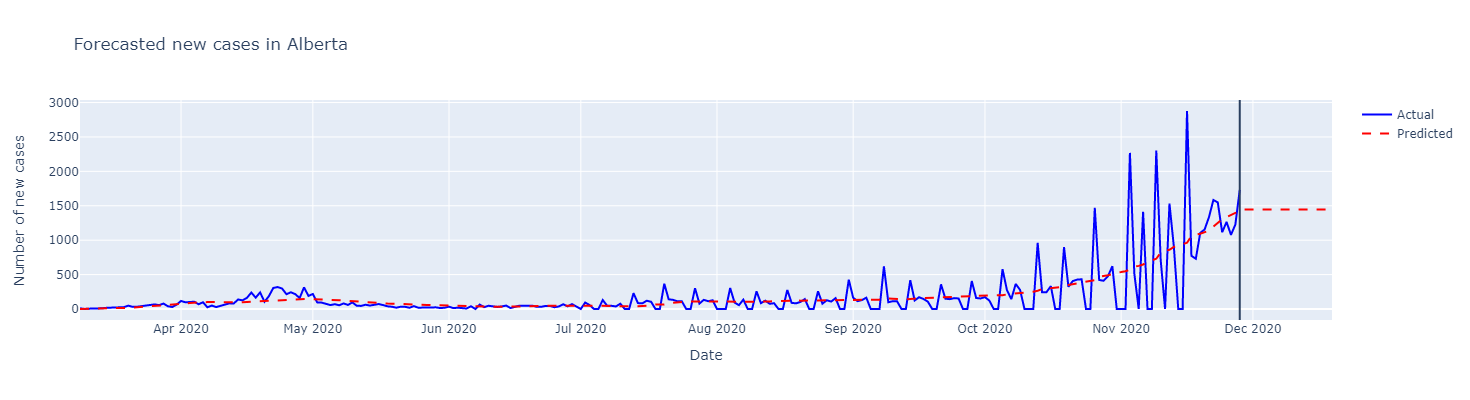

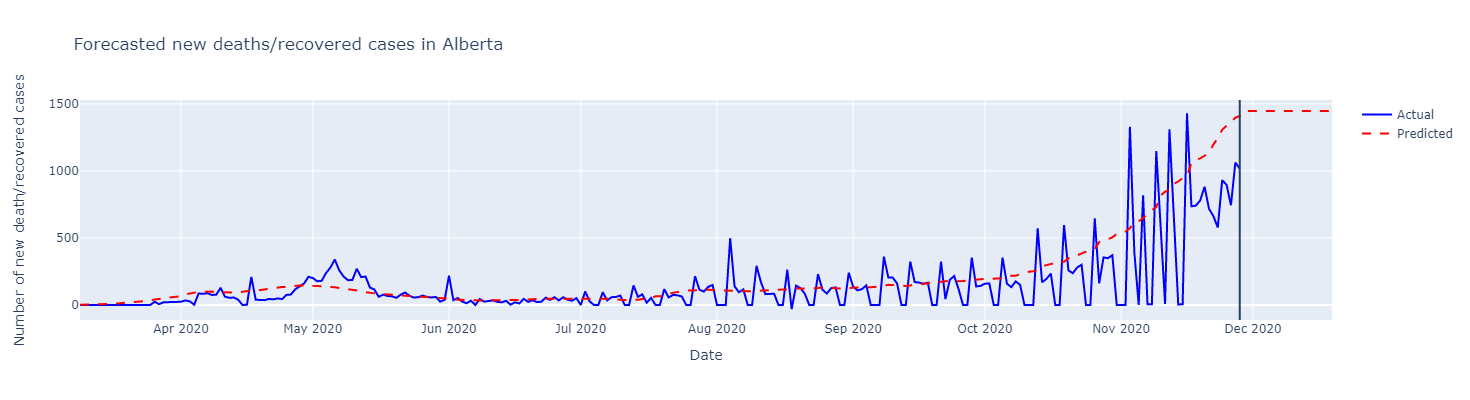

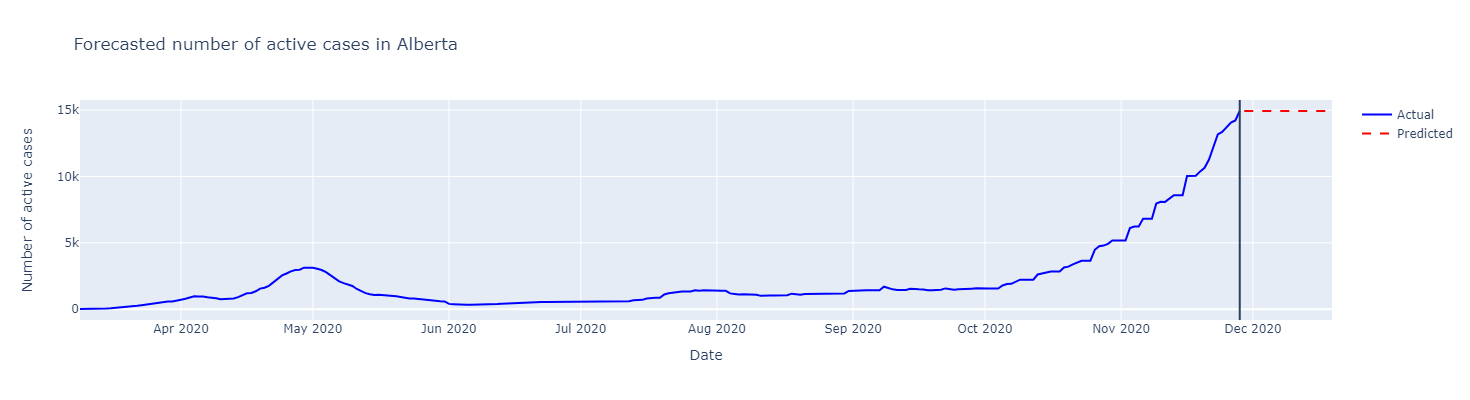

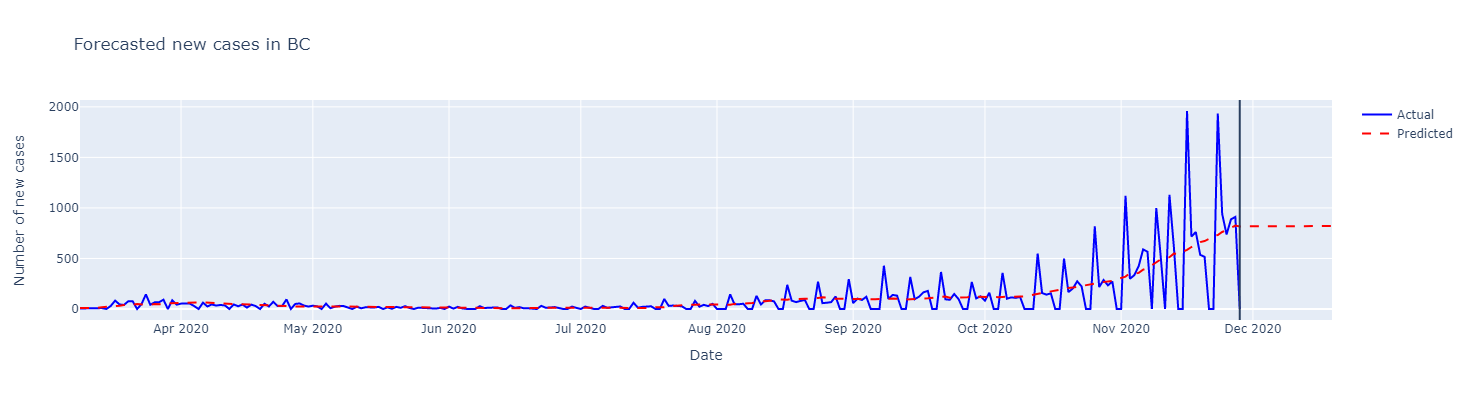

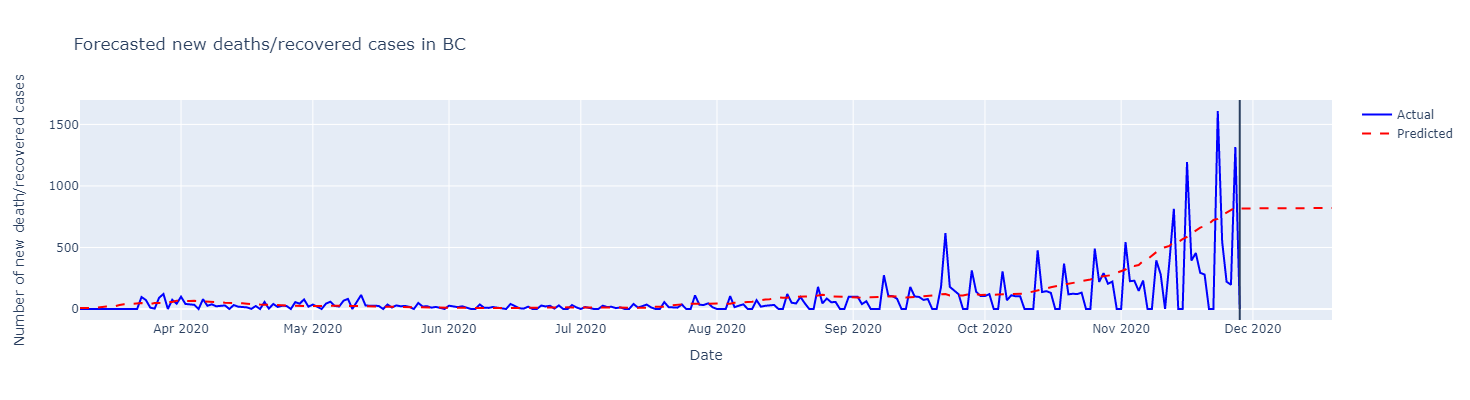

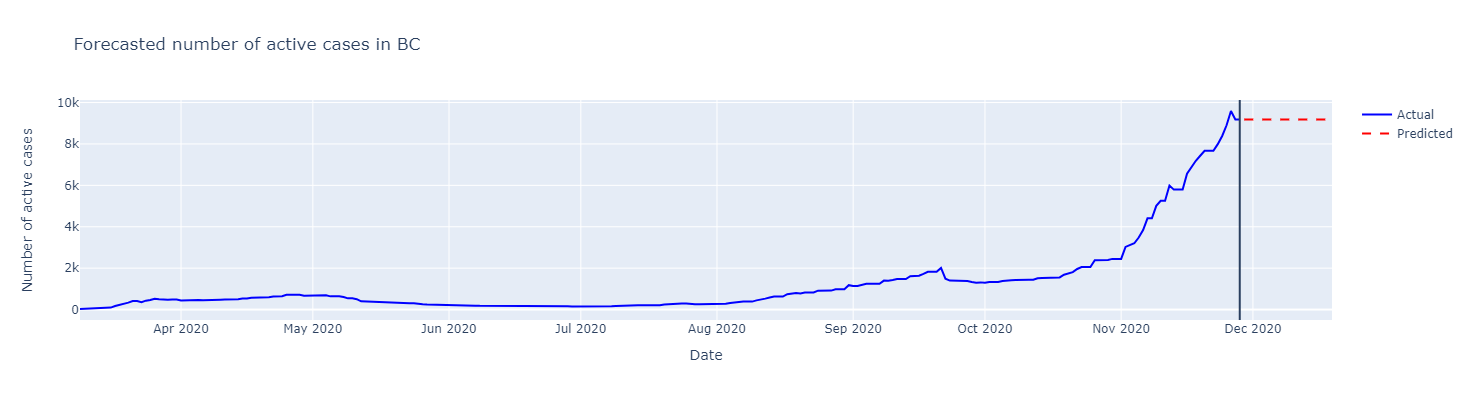

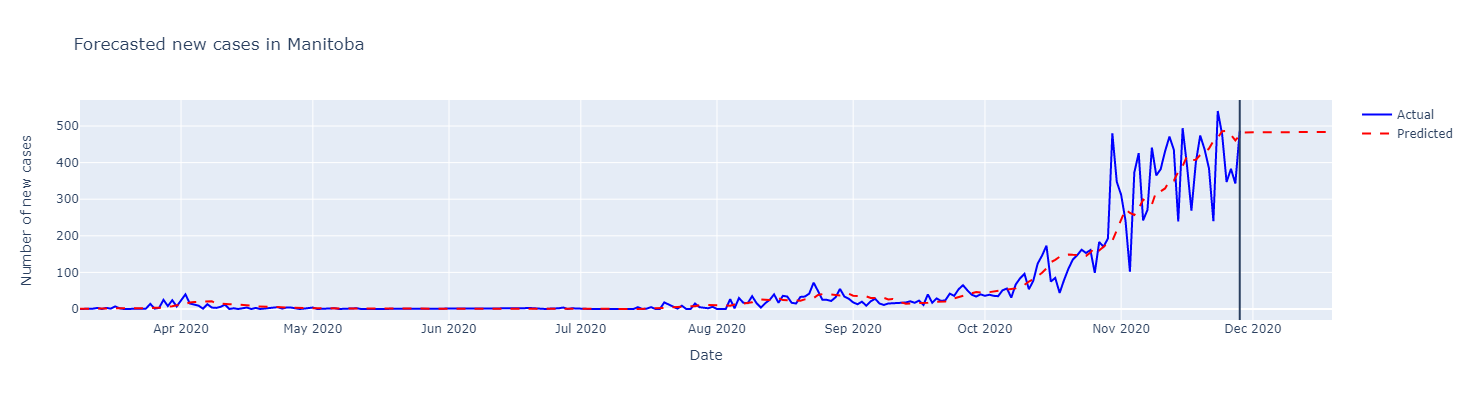

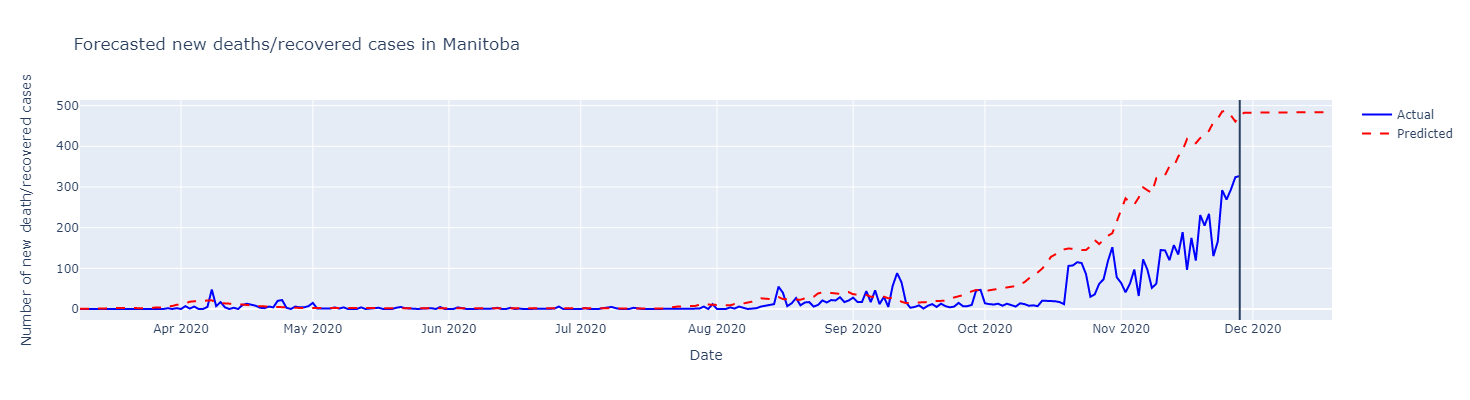

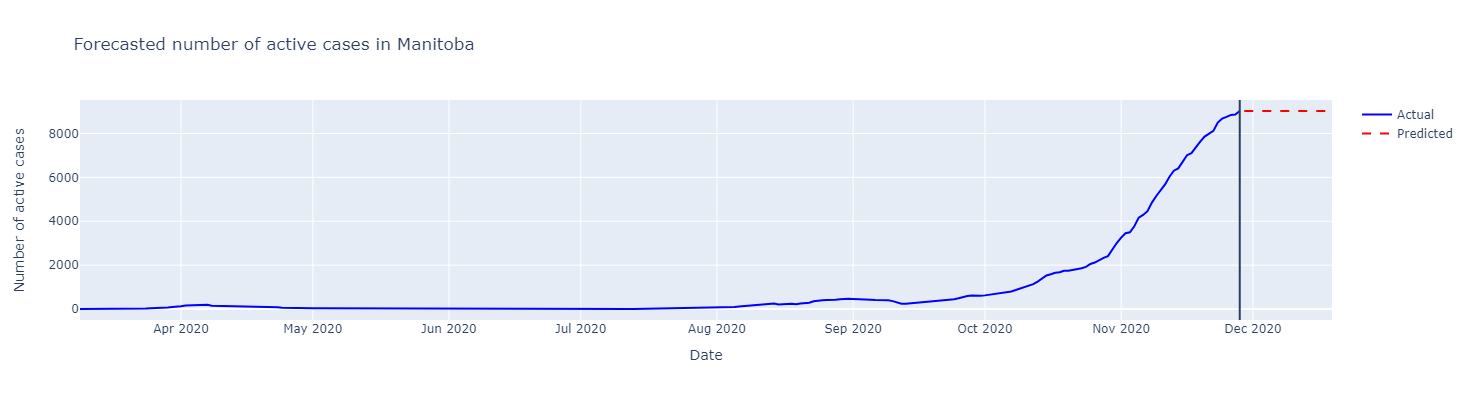

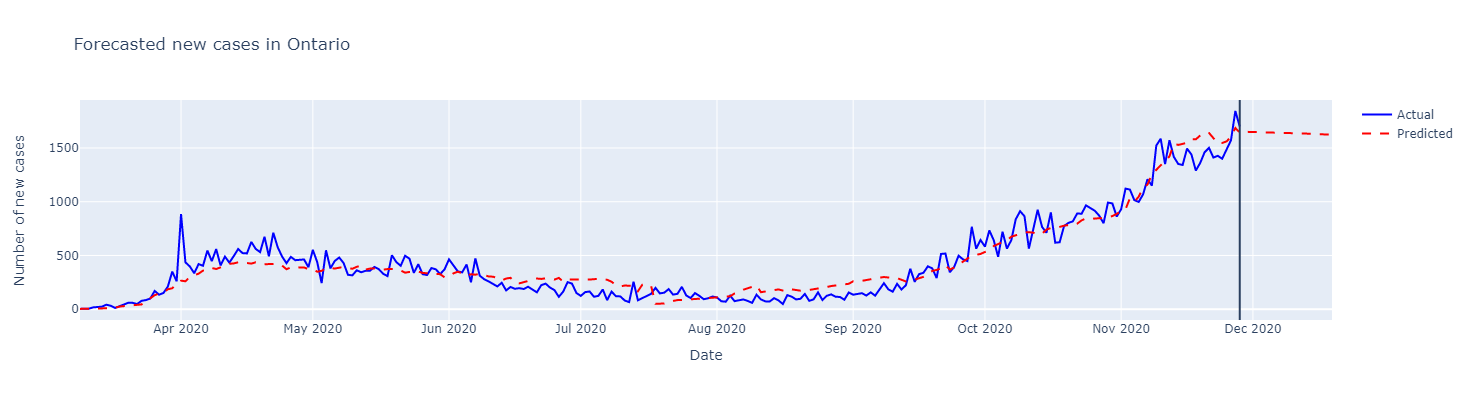

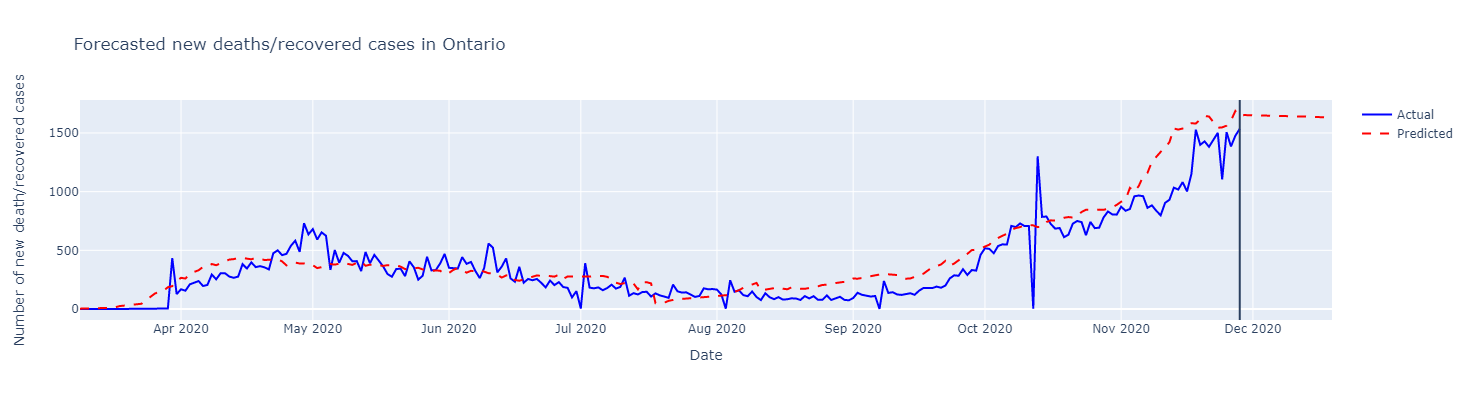

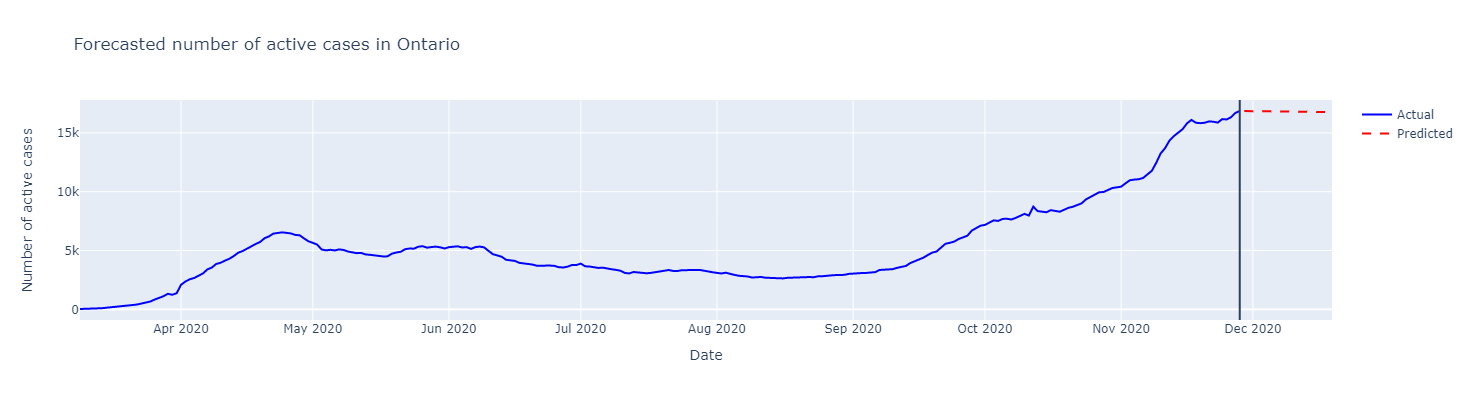

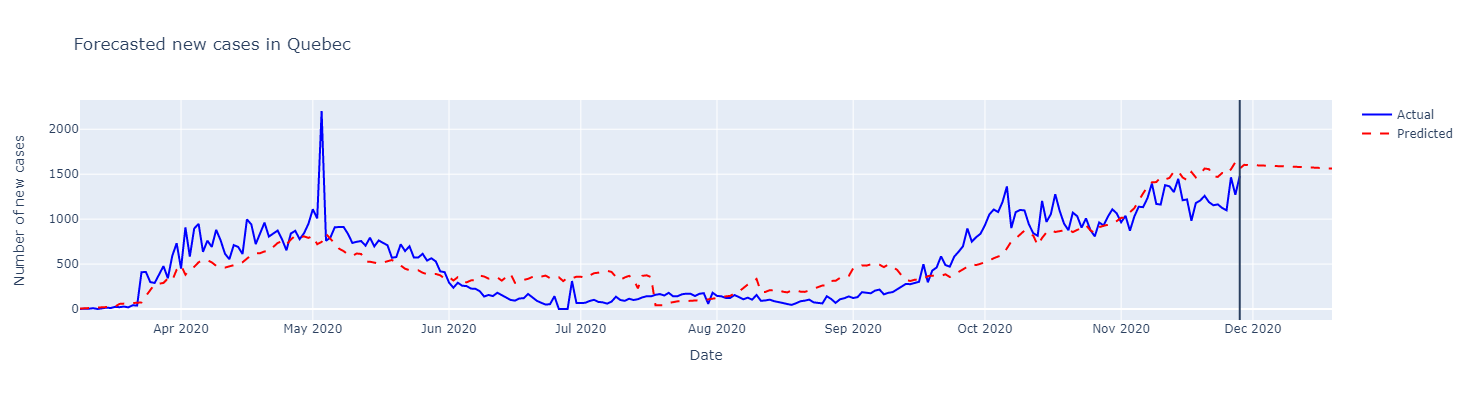

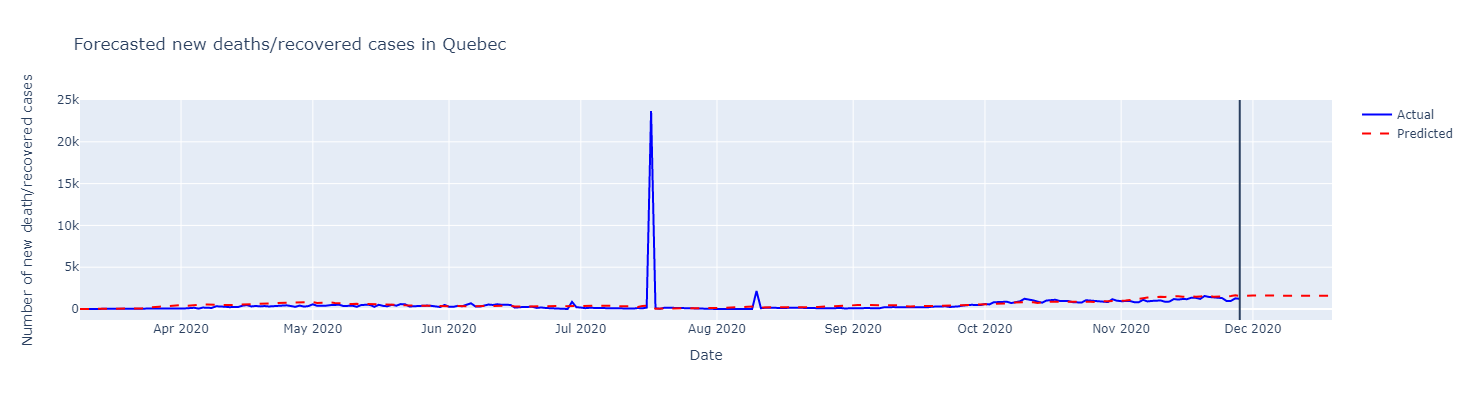

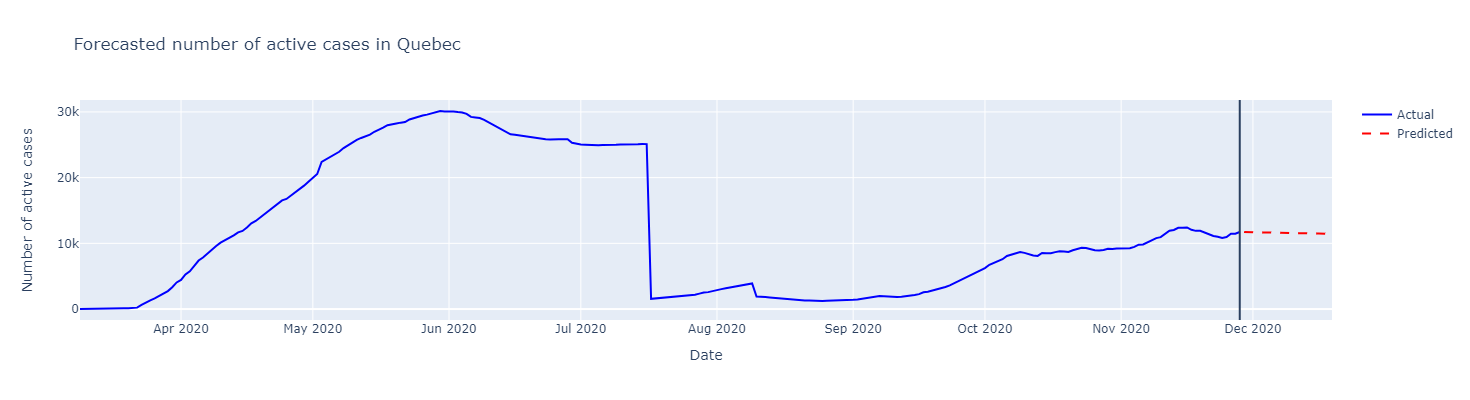

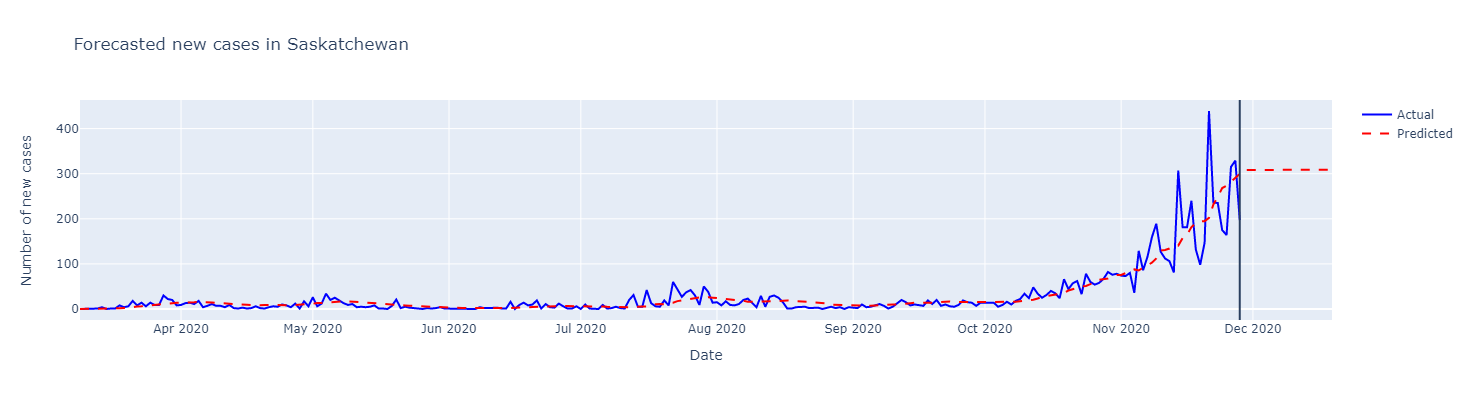

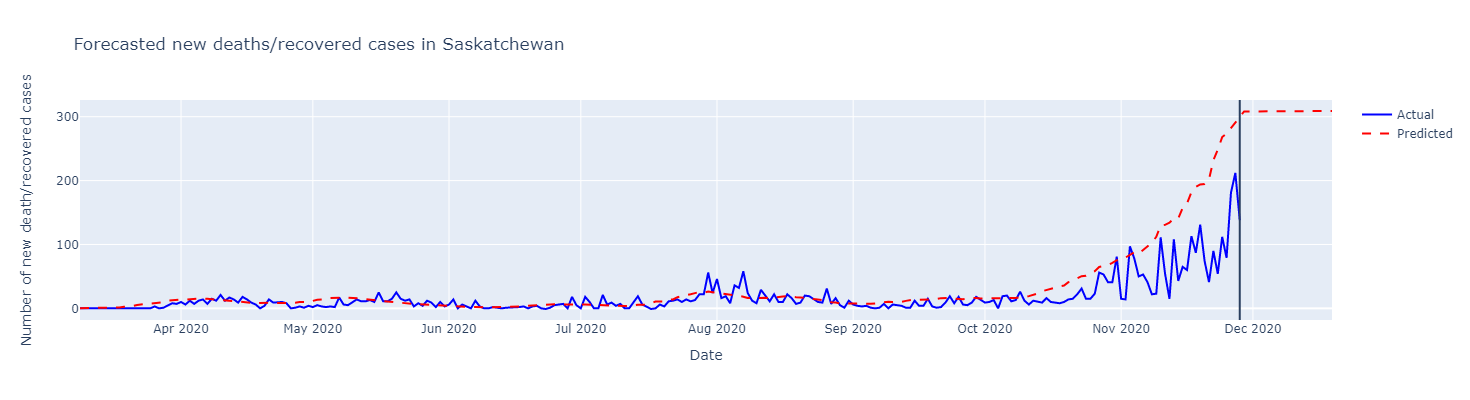

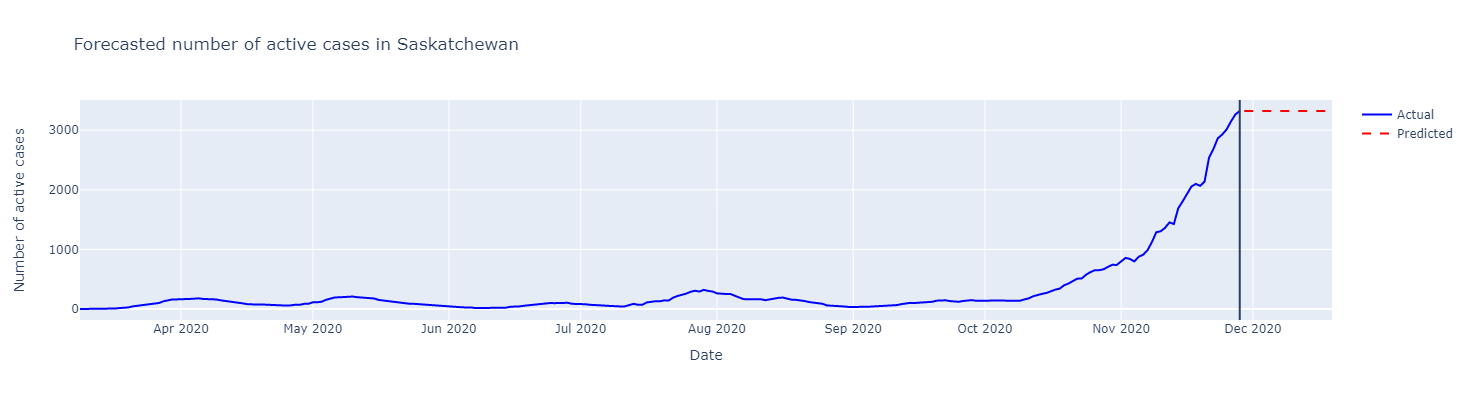

In [8]:
# Prediction plots for all provinces
provinces = active_cases_provinces['province'].unique()
for province in provinces:
    province_forecasts = forecasts.query('province == @province')
    
    plot_predictions(province_forecasts,
                     y = 'cases',
                     y_label = 'Number of new cases',
                     title = f'Forecasted new cases in {province}',
                     include_ci = False)

    plot_predictions(province_forecasts,
                     y = 'removed',
                     y_label = 'Number of new death/recovered cases',
                     title = f'Forecasted new deaths/recovered cases in {province}',
                     include_ci = False)
    
    plot_predictions(province_forecasts,
                     y = 'active_cases',
                     y_label = 'Number of active cases',
                     title = f'Forecasted number of active cases in {province}')

### Comments



### Cross validation